# Simultaneous Investigation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from scipy.integrate import dblquad

In [9]:
max_x, max_y, max_h = 180, 30, 20  # Define your max values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


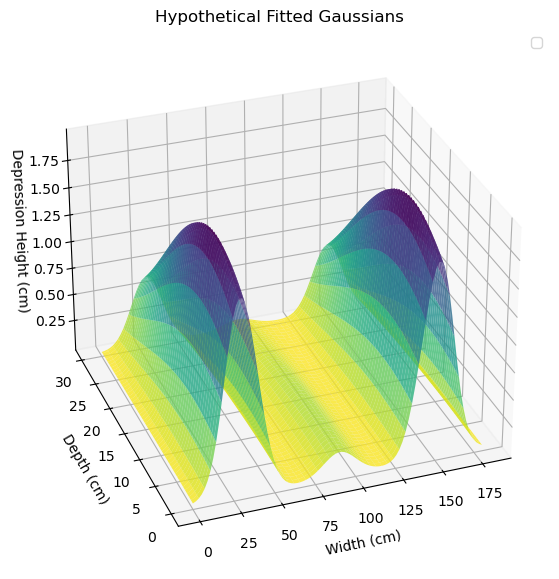

In [29]:
# Function to model a single 2D Gaussian distribution
def gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude):
    x, y = xy
    return amplitude * np.exp(-(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)))

# Function to model a sum of n_gaussians 2D Gaussian distributions
def sum_of_gaussians(xy, *params):
    n_gaussians = len(params) // 5
    result = np.zeros_like(xy[0])
    for i in range(n_gaussians):
        x0, y0, sigma_x, sigma_y, amplitude = params[i*5:(i+1)*5]
        result += gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude)
    return result

# Generate a mesh for visualization
x_mesh = np.linspace(0, max_x, 100)
y_mesh = np.linspace(0, max_y, 100)
X_mesh, Y_mesh = np.meshgrid(x_mesh, y_mesh)
xy_mesh = np.vstack((X_mesh.ravel(), Y_mesh.ravel()))

params = np.array([
    30, 7.5, 10, 15, 2,
    90, 7.5, 10, 15, 0.25,
    150, 7.5, 10, 15, 2
])
H_fit = sum_of_gaussians(xy_mesh, *params).reshape(100, 100)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the best-fit Gaussian surface
ax.plot_surface(X_mesh, Y_mesh, H_fit, cmap='viridis_r', alpha=0.8)

# Set labels and title
ax.set_title("Hypothetical Fitted Gaussians")
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Depth (cm)')
ax.set_zlabel('Depression Height (cm)')
ax.legend()
ax.view_init(elev=30, azim=250)

plt.savefig("figures/simulOutputNegative.png", dpi=300)
plt.show()

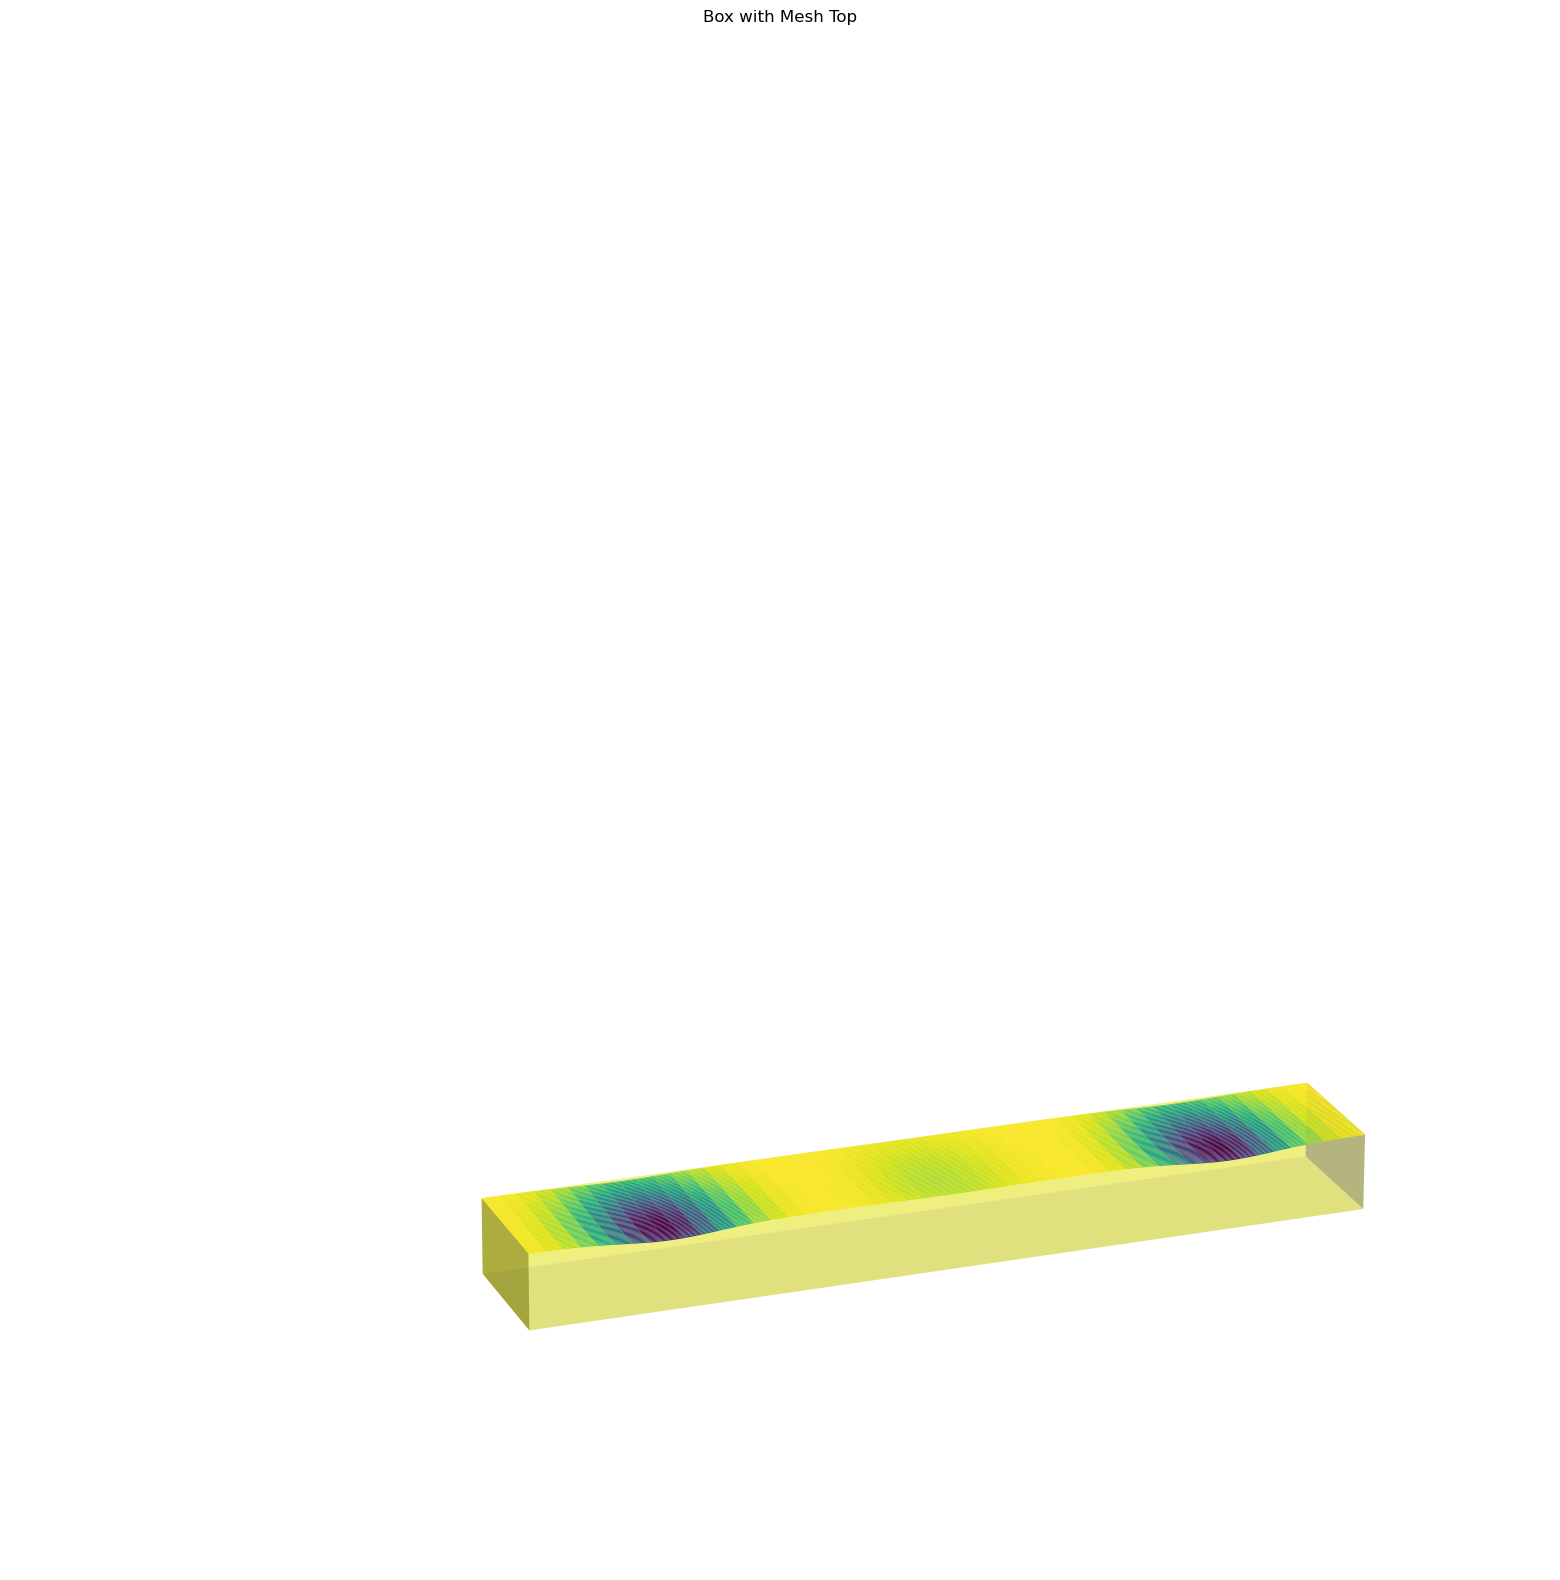

In [33]:
stair_height = max_h
# Plotting
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the box - bottom and four side walls
# Bottom rectangle (0,0,0) to (max_x, max_y, 0)
ax.plot_surface([[0, max_x], [0, max_x]], [[0, 0], [max_y, max_y]], np.zeros((2, 2)), color='yellow', alpha=0.5)

# Side walls (4 vertical walls)
ax.plot_surface(np.array([[0, 0], [0, 0]]), np.array([[0, max_y], [0, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)
#ax.plot_surface(np.array([[0, max_x], [0, max_x]]), np.array([[0, 0], [0, 0]]), np.array([[0, 0], [stair_height, stair_height]]), color='gray', alpha=0.5)
ax.plot_surface(np.array([[0, max_x], [0, max_x]]), np.array([[max_y, max_y], [max_y, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)
ax.plot_surface(np.array([[max_x, max_x], [max_x, max_x]]), np.array([[0, max_y], [0, max_y]]), np.array([[0, 0], [stair_height, stair_height]]), color='yellow', alpha=0.5)

# Top mesh surface (x_grid, y_grid, stair_H)
stair_H_fit = stair_height - H_fit
ax.plot_surface(X_mesh, Y_mesh, stair_H_fit, cmap='viridis', edgecolor='none')

# Set labels
ax.set_title('Box with Mesh Top')
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Depth (cm)')
ax.set_zlabel('Height (cm)')

scaling = np.array([180, 180, 180])

ax.auto_scale_xyz(*[[0, scale] for scale in scaling])

ax.set_axis_off()
ax.view_init(elev=20, azim=250)
plt.savefig("figures/simulOutput.png", dpi=300)
plt.show()

In [37]:
columns = ["x0", "y0", "sigma_x", "sigma_y", "amplitude"]

# Function to compute the value of the 2D Gaussian for a given (x, y)
def gaussian_2d(xy, x0, y0, sigma_x, sigma_y, amplitude):
    x, y = xy
    return amplitude * np.exp(-(((x - x0)**2) / (2 * sigma_x**2) + ((y - y0)**2) / (2 * sigma_y**2)))
    
# Function to calculate the integral of the Gaussian over a region
def integral_gaussian(x_max, y_max, x0, y0, sigma_x, sigma_y, amplitude):
    # Define the bounds for x and y
    def integrand(y, x):  # Note that dblquad expects the y-bound first
        return gaussian_2d((x, y), x0, y0, sigma_x, sigma_y, amplitude)
    
    # Perform the double integration using dblquad
    result, _ = dblquad(integrand, 0, x_max, lambda x: 0, lambda x: y_max)
    
    return result
    
# Reshape the params array into a 2D array (each row corresponds to a Gaussian)
n_gaussians = len(params) // 5
params_table = np.abs(np.array(params).reshape(n_gaussians, 5))

# Create a DataFrame
params_df = pd.DataFrame(params_table, columns=columns)

params_df['integral'] = params_df.apply(
    lambda row: integral_gaussian(max_x, max_y, row['x0'], row['y0'], row['sigma_x'], row['sigma_y'], row['amplitude']),
    axis=1
)

params_df.round(2)

,x0,y0,sigma_x,sigma_y,amplitude,integral
0,30.0,7.5,10.0,15.0,2.00,1175.86
1,90.0,7.5,10.0,15.0,0.25,147.18
2,150.0,7.5,10.0,15.0,2.00,1175.86
